In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, when, exp, radians, cos, sin, mean, avg, max as spark_max, min as spark_min,
    sum as spark_sum, lag
)
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, desc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("wildfire project").getOrCreate()

# Path to the data directory (do not specify a file name, just the directory)
data_dir = "/content/data"

# Load all CSV files in the directory
df = spark.read.csv(data_dir, header=True, inferSchema=True).cache()

# df.show(10)



In [3]:
 df.printSchema()

root
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- weather_latitude: double (nullable = true)
 |-- weather_longitude: double (nullable = true)
 |-- temperature_2m_max: double (nullable = true)
 |-- temperature_2m_min: double (nullable = true)
 |-- temperature_2m_mean: double (nullable = true)
 |-- apparent_temperature_max: double (nullable = true)
 |-- apparent_temperature_min: double (nullable = true)
 |-- apparent_temperature_mean: double (nullable = true)
 |-- daylight_duration: double (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- precipitation_sum: double (nullable = true)
 |-- rain_sum: double (nullable = true)
 |-- snowfall_sum: double (nullable = true)
 |-- precipitation_hours: double (nullable = true)
 |-- wind_speed_10m_max: double (nullable = true)
 |-- wind_gusts_10m_max: double (nullable = true)
 |-- wind_direction_10m_dominant: double (nullable = true)
 |-- shortwave_radiation_sum: double (nullable = true)
 |-- et0_fao

In [4]:
df.summary().show()

+-------+-------------+------------------+-------------------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------------+-----------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+-----------------+------------------+------------------+------------------+--------+--------------------+---------------------+---------------------+----------------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------------------+
|summary|         city|  weather_latitude|  weather_longitude|temperature_2m_max|temperature_2m_min|temperature_

In [5]:
from pyspark.sql.functions import when

df = df.withColumn("wildfire", when(col("instrument") == "MODIS", 1).otherwise(0))

In [ ]:
df.summary().show()

+-------+-------------+------------------+-------------------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+---------------------------+-----------------------+--------------------------+------------------+------------------+------------------+------------------+------------------+---------+----------+-----------------+------------------+------------------+------------------+--------+--------------------+---------------------+---------------------+----------------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+-------------------+--------------------------+------------------+
|summary|         city|  weather_latitude|  weather_longitude|temperature_2m_max|temperature_

In [6]:
from pyspark.sql.functions import spark_partition_id
df.coalesce(1).write.csv('/content/data/wildfires.csv', header=True, mode="overwrite")

# Wildfires Trend Over Time

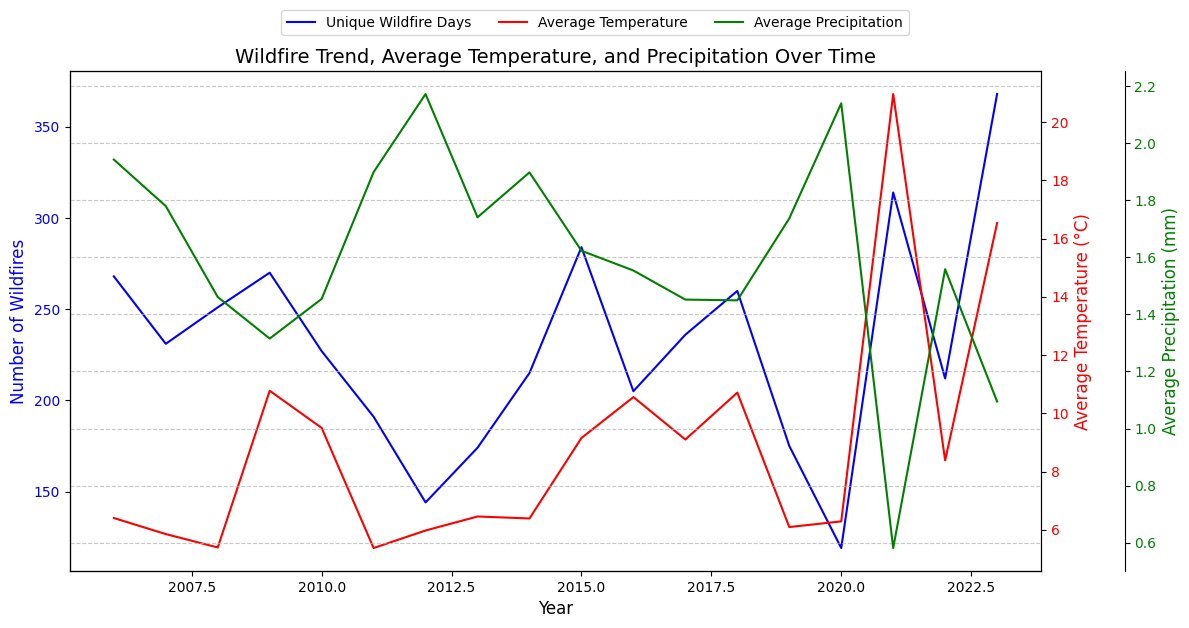

In [14]:
wildfires = df.filter(col("wildfire") == 1)
wildfires_with_year = wildfires.withColumn("year", year(col("date")))
wildfire_trend = wildfires_with_year.groupBy("year", "date", "city") \
    .agg(count("*").alias("daily_wildfire_count")) \
    .groupBy("year") \
    .agg(countDistinct("date", "city").alias("unique_wildfire_days")) \
    .orderBy("year")

wildfire_trend_pd = wildfire_trend.toPandas()

# Calculate average temperature per year using 'temperature_2m_mean'
avg_temp_per_year = df.groupBy(year(col("date")).alias("year")) \
    .agg(avg("temperature_2m_mean").alias("avg_temperature")) \
    .orderBy("year")

# Calculate average precipitation per year
avg_precip_per_year = df.groupBy(year(col("date")).alias("year")) \
    .agg(avg("precipitation_sum").alias("avg_precipitation")) \
    .orderBy("year")


# Convert all DataFrames to Pandas for plotting
wildfire_trend_pd = wildfire_trend.toPandas()
avg_temp_pd = avg_temp_per_year.toPandas()
avg_precip_pd = avg_precip_per_year.toPandas()  # Convert to Pandas

fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust figure size

# Plot wildfire trend (primary y-axis)
ax1.plot(wildfire_trend_pd["year"], wildfire_trend_pd["unique_wildfire_days"], \
         color="blue", label="Unique Wildfire Days")
ax1.set_xlabel("Year", fontsize=12)  # Increase font size
ax1.set_ylabel("Number of Wildfires", color="blue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="blue")

# Average temperature (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(avg_temp_pd["year"], avg_temp_pd["avg_temperature"], color="red", label="Average Temperature")
ax2.set_ylabel("Average Temperature (°C)", color="red", fontsize=12)  # Add units
ax2.tick_params(axis="y", labelcolor="red")

# Average precipitation (tertiary y-axis)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis spine
ax3.plot(avg_precip_pd["year"], avg_precip_pd["avg_precipitation"], color="green", label="Average Precipitation")
ax3.set_ylabel("Average Precipitation (mm)", color="green", fontsize=12)  # Add units
ax3.tick_params(axis="y", labelcolor="green")

# Improved legend placement
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=10)

# Title and grid
plt.title("Wildfire Trend, Average Temperature, and Precipitation Over Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  # Customize grid

plt.tight_layout()  # Adjust layout
plt.show()

This chart visualizes the relationship between wildfire count, average temperature, and average precipitation over time. Key observations include the correlation between temperature, precipitation, and wildfire activity. The blue line represents wildfire count, the red line indicates average temperature, and the green line corresponds to average precipitation.

In years with higher average temperatures, such as 2016 and 2021, there is a noticeable increase in wildfire count, suggesting a potential link between temperature and wildfire activity. Conversely, years with higher average precipitation generally show lower wildfire counts, indicating precipitation may act as a mitigating factor for wildfires. The interplay between these variables highlights how climatic factors like temperature and precipitation contribute to wildfire dynamics, underscoring the importance of understanding environmental influences for better wildfire management.

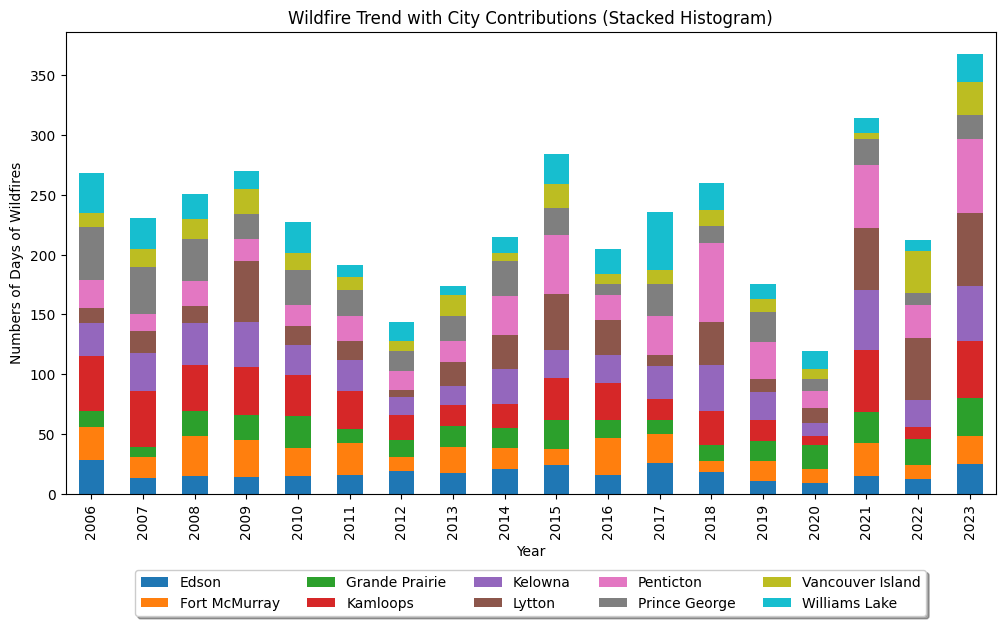

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate unique wildfire days per city per year
wildfires = df.filter(col("wildfire") == 1)
wildfires_with_year_city = wildfires.withColumn("year", year(col("date")))
wildfire_counts = wildfires_with_year_city.groupBy("year", "date", "city") \
    .agg(count("*").alias("daily_wildfire_count")) \
    .groupBy("year", "city") \
    .agg(countDistinct("date").alias("unique_wildfire_days")) \
    .orderBy("year", "city")

wildfire_counts_pd = wildfire_counts.toPandas()

# Pivot the DataFrame to create a suitable format for stacked histogram
wildfire_counts_pivot = wildfire_counts_pd.pivot(index='year', columns='city', values='unique_wildfire_days')

# Create the stacked histogram
wildfire_counts_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)
plt.xlabel('Year')
plt.ylabel('Numbers of Days of Wildfires')
plt.title('Wildfire Trend with City Contributions (Stacked Histogram)')

# Display the plot
plt.show()

This stacked histogram visualizes the annual trend of wildfires across various cities from 2006 to 2023, with contributions from specific cities represented by different colors. The y-axis shows the total number of wildfires, while the x-axis represents the years. Each segment in a bar corresponds to the number of wildfires reported in a particular city, allowing for a clear comparison of contributions by location over time.

Key observations include a noticeable spike in wildfire occurrences in 2015 and 2023, indicating potentially extreme conditions during those years. Conversely, years like 2012 and 2020 exhibit relatively lower wildfire counts. Among the cities, locations such as Prince George, Kamloops, and Penticton seem to consistently contribute a significant portion to the total wildfire count, reflecting areas of high fire activity. This trend suggests that wildfire management efforts might need to prioritize these cities due to their recurrent vulnerability.

From 2020 to 2021, there is a significant leap in the total number of wildfires, as illustrated by the marked increase in the bar height. This sharp rise suggests a drastic shift in environmental conditions or other contributing factors, such as prolonged droughts, higher temperatures, or increased human activities during this period. The cities of **Kamloops, Penticton, Kelowna and Lytton** appear to play a prominent role in this increase, with larger segments in 2021 compared to 2020. This jump highlights the need to investigate and address the underlying causes of such spikes to mitigate future wildfire risks.

# 2020 to 2021, A Giantic Increase In The Number of Days of Wildfires.

+----------------+-------------+
|            city|wildfire_days|
+----------------+-------------+
|        Kamloops|          542|
|       Penticton|          539|
|         Kelowna|          509|
|          Lytton|          492|
|   Prince George|          416|
|   Fort McMurray|          377|
|   Williams Lake|          359|
|  Grande Prairie|          334|
|           Edson|          314|
|Vancouver Island|          262|
+----------------+-------------+



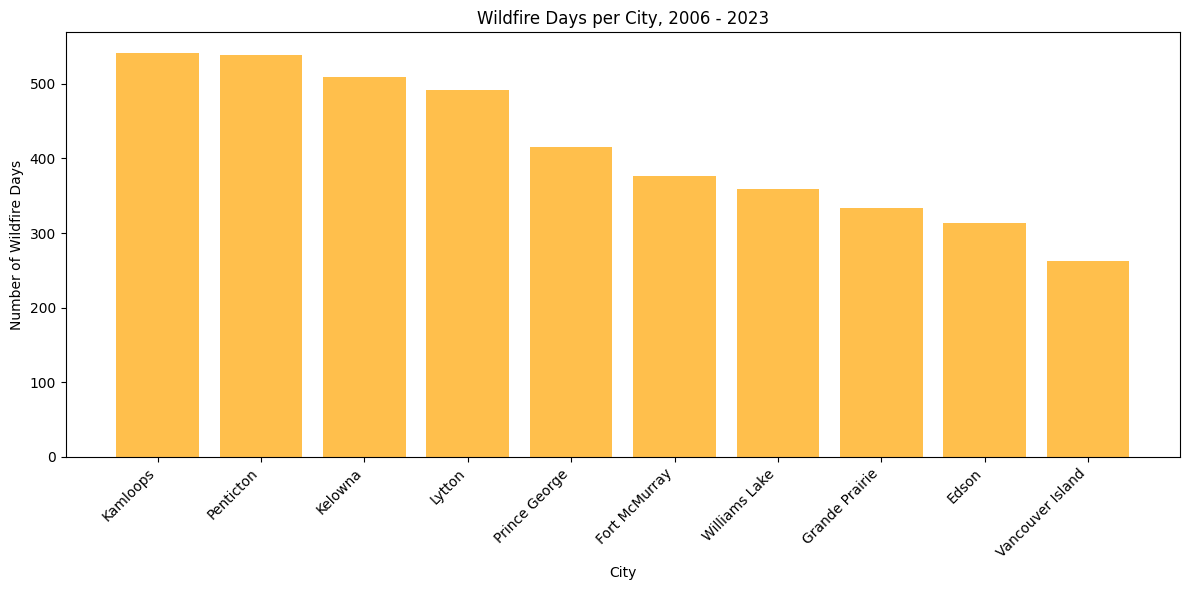

In [22]:
from pyspark.sql.functions import countDistinct

# Filter for wildfire occurrences (wildfire == 1)
wildfires = df.filter(col("wildfire") == 1)

# Group by city and count distinct dates
wildfire_days_per_city = wildfires.groupBy("city") \
    .agg(countDistinct("date").alias("wildfire_days")) \
    .orderBy(desc("wildfire_days"))  # Order by descending wildfire days

# Convert to Pandas DataFrame for further analysis or plotting (if needed)
wildfire_days_per_city_pd = wildfire_days_per_city.toPandas()

# Show the result (or proceed with plotting)
wildfire_days_per_city.show()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(wildfire_days_per_city_pd['city'], wildfire_days_per_city_pd['wildfire_days'],
        color='orange', alpha=0.7)  # Customize color and alpha

plt.xlabel('City')
plt.ylabel('Number of Wildfire Days')
plt.title('Wildfire Days per City, 2006 - 2023')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


This bar chart shows the total number of wildfire days recorded for each city. Kamloops and Penticton lead with the highest numbers of wildfire days, both exceeding 500 days, indicating that these cities experience prolonged and frequent wildfire activity compared to others. This trend highlights them as high-risk areas requiring more focused wildfire prevention and mitigation strategies.

Cities like Vancouver Island and Edson are at the lower end of the spectrum, with fewer wildfire days, suggesting they face relatively less frequent or severe wildfire conditions. However, even these cities are not immune to wildfires, emphasizing the need for consistent monitoring and preparedness across all regions. Overall, the distribution suggests significant geographic variability in wildfire patterns, influenced by local climate, vegetation, and possibly human activities.

In [24]:
from pyspark.sql.functions import year, avg, when, sum as spark_sum

# Filter for the specified cities and years
filtered_df = df.filter(
    (col("city").isin(["Penticton", "Lytton", "Kelowna", "Kamloops"])) &
    (year(col("date")).isin([2020, 2021]))
)

# Group by city, year, and calculate average values for features
city_year_features = filtered_df.groupBy("city", year(col("date")).alias("year")) \
    .agg(
        avg("temperature_2m_mean").alias("avg_temperature"),
        avg("new_dryness_index").alias("avg_dryness_index"),
        avg("precipitation_sum").alias("avg_precipitation"),
        avg("sunshine_duration").alias("avg_sunshine"),  # Corrected column name
        avg("daylight_duration").alias("avg_daylight"),
        avg("et0_fao_evapotranspiration").alias("avg_et0_fao_evapotranspiration"),
        avg("new_relative_humidity").alias("avg_relative_humidity_2m"),
        # Add other features you want to compare here
    ) \
    .orderBy("city", "year")

# Pivot the table for easier comparison
features_pivot = city_year_features.groupBy("city") \
    .pivot("year", [2020, 2021]) \
    .agg(
        # Select the average values for each feature
        # Use the appropriate aggregation function if needed (e.g., spark_sum, spark_max)
        avg("avg_temperature").alias("avg_temperature"),
        avg("avg_dryness_index").alias("avg_dryness_index"),
        avg("avg_precipitation").alias("avg_precipitation"),
        avg("avg_sunshine").alias("avg_sunshine"),  # Corrected column name
        avg("avg_daylight").alias("avg_daylight"),
        avg("avg_et0_fao_evapotranspiration").alias("avg_et0_fao_evapotranspiration"),
        avg("avg_relative_humidity_2m").alias("avg_relative_humidity_2m"),
        # Add other features and aggregation functions here
    ) \
    .orderBy("city")

# Show the comparison table
features_pivot.show()

+---------+--------------------+----------------------+----------------------+------------------+------------------+-----------------------------------+-----------------------------+--------------------+----------------------+----------------------+-----------------+------------------+-----------------------------------+-----------------------------+
|     city|2020_avg_temperature|2020_avg_dryness_index|2020_avg_precipitation| 2020_avg_sunshine| 2020_avg_daylight|2020_avg_et0_fao_evapotranspiration|2020_avg_relative_humidity_2m|2021_avg_temperature|2021_avg_dryness_index|2021_avg_precipitation|2021_avg_sunshine| 2021_avg_daylight|2021_avg_et0_fao_evapotranspiration|2021_avg_relative_humidity_2m|
+---------+--------------------+----------------------+----------------------+------------------+------------------+-----------------------------------+-----------------------------+--------------------+----------------------+----------------------+-----------------+------------------+--------

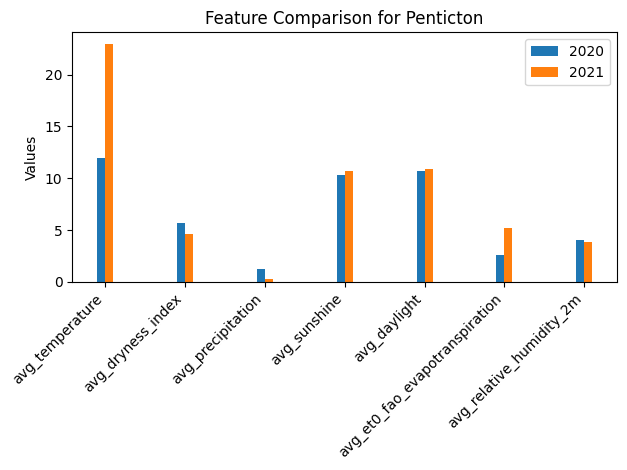

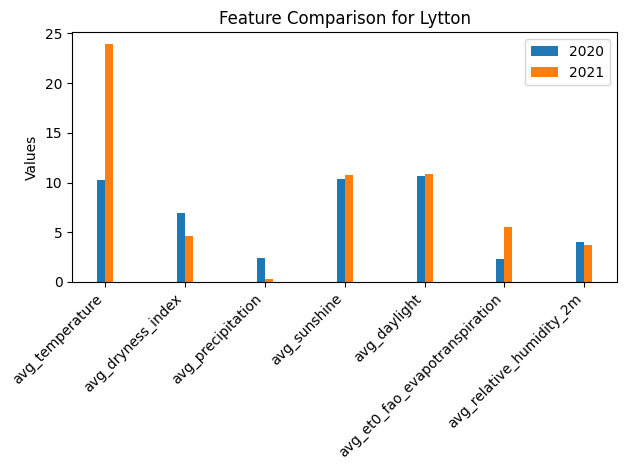

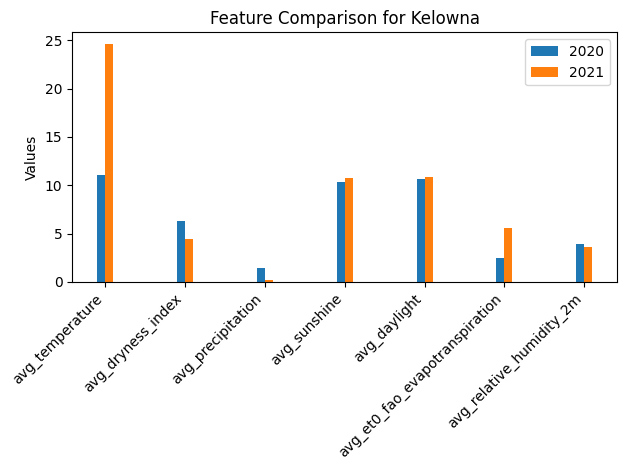

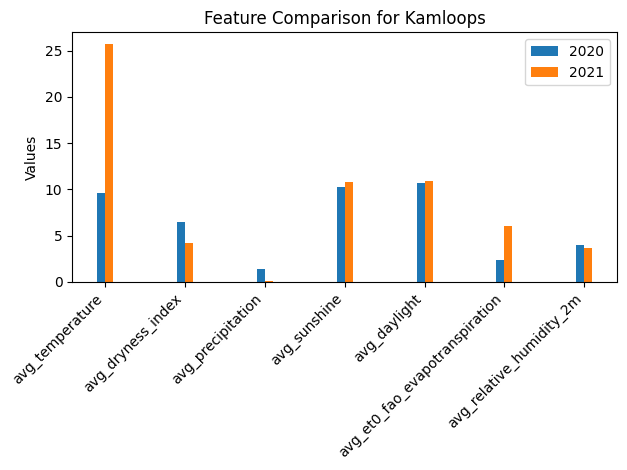

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# List of cities
cities = ["Penticton", "Lytton", "Kelowna", "Kamloops"]

# List of features to compare (without year prefix)
features = ['avg_temperature', 'avg_dryness_index', 'avg_precipitation', 'avg_sunshine',
            'avg_daylight', 'avg_et0_fao_evapotranspiration', 'avg_relative_humidity_2m']

features_pivot_pd = features_pivot.toPandas()

# Rename columns for better clarity and plotting
features_pivot_pd.columns = [
    col.replace("2020_", "2020_").replace("2021_", "2021_") for col in features_pivot_pd.columns
]

# Create a figure and axes for each city
for city in cities:
    city_data = features_pivot_pd[features_pivot_pd['city'] == city]

    # Extract data for 2020 and 2021
    values_2020 = city_data[[f'2020_{feature}' for feature in features]].values.flatten()
    values_2021 = city_data[[f'2021_{feature}' for feature in features]].values.flatten()

    # Apply log transformation to sunshine, daylight, and relative humidity
    sunshine_index = features.index('avg_sunshine')
    daylight_index = features.index('avg_daylight')
    humidity_index = features.index('avg_relative_humidity_2m')  # Get index of humidity


    # Regularizing features
    values_2020[sunshine_index] = np.log1p(values_2020[sunshine_index])
    values_2020[daylight_index] = np.log1p(values_2020[daylight_index])
    values_2020[humidity_index] = np.log1p(values_2020[humidity_index])

    values_2021[sunshine_index] = np.log1p(values_2021[sunshine_index])
    values_2021[daylight_index] = np.log1p(values_2021[daylight_index])
    values_2021[humidity_index] = np.log1p(values_2021[humidity_index])

    # print(values_2020)
    # print(values_2021)

    # Set up the bar positions
    x = np.arange(len(features))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, values_2020, width, label='2020')
    rects2 = ax.bar(x + width/2, values_2021, width, label='2021')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title(f'Feature Comparison for {city}')
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45, ha='right')  # Rotate x-axis labels
    ax.legend()

    fig.tight_layout()
    plt.show()

This image presents a feature comparison for multiple cities (Penticton, Lytton, Kelowna, and Kamloops) between the years 2020 and 2021. Key environmental variables such as average temperature, dryness index, precipitation, sunshine, daylight, evapotranspiration, and relative humidity are plotted to observe differences across these years.

For all cities, average temperature and dryness index appear significantly higher in 2021 compared to 2020, which likely contributed to the increased wildfire activity in 2021. Other factors like average precipitation are noticeably lower in 2021, indicating drier conditions. Metrics such as sunshine and daylight hours remain relatively consistent across years, while evapotranspiration and relative humidity exhibit minor variations. These comparisons suggest that elevated temperatures and decreased precipitation were critical factors in the heightened wildfire risks observed in 2021.